In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# This code demonstrates the use of BERT-based models as Transfomers for text, in the application of classification of sentiment from the IMDB Dataset obtained from Kaggle

In [3]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 54.8 MB/s 
     |████████████████████████████████| 2.8 MB 41.8 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 53.6 MB/s 
     |████████████████████████████████| 981 kB 60.9 MB/s 
     |████████████████████████████████| 263 kB 50.3 MB/s 
     |████████████████████████████████| 468 kB 52.5 MB/s 
     |████████████████████████████████| 3.3 MB 46.8 MB/s 
     |████████████████████████████████| 880 kB 44.9 MB/s 
     |████████████████████████████████| 101 kB 10.1 MB/s 
     |████████████████████████████████| 596 kB 13.9 MB/s 
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=dc2d67bbd199532f05cc6035f12ce1c0860f6d303eb62fa7e0dc49676aabe7b0
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9154b907eacbc4ac99499a99ae829b

In [2]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 38.4 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=e806f3f10759b43652b7983eab11f393bc4091ee7e7aee7881c77a37d30fef01
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [4]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import string
import re
from cleantext import clean

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

import nltk
# nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
sw = set(stopwords.words('english'))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [9]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/PGSS2022/L3-7-8-2022/IMDB Dataset.csv")

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
cleaned_df = []

for i in df["review"]:
    i = clean(i,no_urls=True, replace_with_url="", no_digits=True,
              replace_with_digit="",fix_unicode = True, lower = True)
    
    cleaned_df.append(i)
  


In [13]:
cleaned_df[:2]

["one of the other reviewers has mentioned that after watching just oz episode you'll be hooked. they are right, as this is exactly what happened with me.<br /><br />the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.<br /><br />it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />i would say the main appeal of the show is due to the fac

In [14]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
            if c == '<' and not quote:
                tag = True
            elif c == '>' and not quote:
                tag = False
            elif (c == '"' or c == "'") and tag:
                quote = not quote
            elif not tag:
                out = out + c

    return out

In [16]:
cleaned_df2 = []

for i, _ in enumerate(cleaned_df):
    cleanedtemp = remove_html_markup(cleaned_df[i])
    cleaned_df2.append(cleanedtemp)
  
cleaned_df2[0]

"one of the other reviewers has mentioned that after watching just oz episode you'll be hooked. they are right, as this is exactly what happened with me.the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.i would say the main appeal of the show is due to the fact that it goes where other shows woul

In [ ]:
finalText= []
for i in cleaned_df2:
    tokens = word_tokenize(i)
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if not w in sw]
    s = " "
    temp = s.join(words)
    finalText.append(temp)

In [30]:
df["cleaned"] = finalText
df['sentiment'] = df['sentiment'].astype('str') 
df['sentiment'][df['sentiment']=='positive'] = 1
df['sentiment'][df['sentiment']=='negative'] = 0
df.head()

,review,sentiment,cleaned
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...


In [31]:
df['sentiment'] = df['sentiment'].astype('category') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   review     50000 non-null  object  
 1   sentiment  50000 non-null  category
 2   cleaned    50000 non-null  object  
dtypes: category(1), object(2)
memory usage: 830.3+ KB


In [32]:
df['sentiment'].value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

In [57]:
from random import sample
sample(range(0,50000),10)

[1985, 2958, 18569, 26168, 14261, 1921, 2210, 34745, 36247, 46398]

In [58]:
randomsampleSet = sample(range(0,50000),1000)
x = df["cleaned"].values[randomsampleSet]
y = df["sentiment"].astype('str').values[randomsampleSet]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [60]:
MODEL_NAME = 'distilbert-base-uncased-distilled-squad'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=[0,1])

In [61]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=10)

preprocessing train...
language: en
train sequence lengths:
	mean : 114
	95percentile : 273
	99percentile : 448


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 118
	95percentile : 318
	99percentile : 431


In [63]:
trn.x[0].shape

(3, 500)

In [54]:
learner.lr_find(show_plot=True, max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
 381/3500 [==>...........................] - ETA: 29:43 - loss: 0.6918 - accuracy: 0.5226

In [ ]:
learner.fit_onecycle(3e-5, 5)

In [65]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.save('myModel')

In [69]:
testRandom = sample(range(0,50000),100)
testSet = list(df["cleaned"][testRandom])
actuals = df['sentiment'].astype('str').values[testRandom]
predictions = predictor.predict(testSet)

myTestSet = pd.DataFrame({'Data': testSet, 'Actual': actuals, 'Predictions': predictions})
pd.crosstab(myTestSet["Actual"],myTestSet["Predictions"] )

Predictions,0,1
Actual,,
0,43,13
1,7,37


# Reload a saved model

In [72]:
# import pickle
# from tensorflow.keras.models import load_model
# # loading preprocess and model file
# features = pickle.load(open('/content/myModel/tf_model.preproc',
#                             'rb'))
# new_model = load_model('/content/myModel/tf_model.h5')
# labels = [0, 1]

# text = 'one of the other reviewers has mentioned that after watching just oz episode you'll be hooked. they are right, as this is exactly what happened with me.<br /><br />the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.<br /><br />it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.'
# preproc_text = features.preprocess([text])
# result = new_model.predict(preproc_text)

In [79]:
predictor = ktrain.load_predictor('myModel')

prediction = predictor.predict(testSet[10])
print(prediction)

0


In [87]:
randomsampleSet = sample(range(0,50000),10)

predictions = predictor.predict(df["cleaned"].values[randomsampleSet])
prediction_proba = predictor.predict_proba(df["cleaned"].values[randomsampleSet])[:,1]

output = pd.DataFrame({'Text': df["cleaned"].values[randomsampleSet], 'Actual': df["sentiment"].values[randomsampleSet], 'Proba':prediction_proba,  'Predictions':predictions })

output

,Text,Actual,Proba,Predictions
0,story screenplay seems written high schooler a...,0,0.023257,0
1,found film quite expressive way main character...,1,0.826463,1
2,amazed early performance clint eastwood read s...,1,0.974647,1
3,first wan na say big naruto fan love anime man...,0,0.507272,1
4,film nt good able catch film festival nt appre...,0,0.434191,0
5,plot tight acting flawless directing script sc...,1,0.031281,0
6,movie really looking forward disappointed expe...,0,0.493395,0
7,totally disagree reviewsall basically negative...,1,0.022109,0
8,opinion movie entire video portion movie absol...,0,0.062755,0
9,film one waited see time glad find everything ...,1,0.982467,1


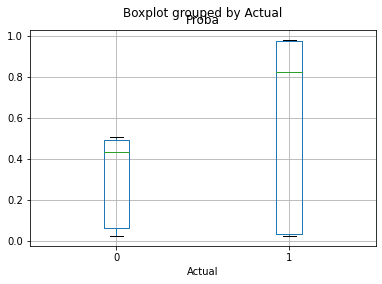

In [88]:
output.boxplot('Proba', 'Actual')

In [89]:
# randomsampleSet = sample(range(0,50000),10)

predictions = predictor.predict(df["review"].values[randomsampleSet])
prediction_proba = predictor.predict_proba(df["cleaned"].values[randomsampleSet])[:,1]

output2 = pd.DataFrame({'Text': df["cleaned"].values[randomsampleSet], 'Actual': df["sentiment"].values[randomsampleSet], 'Proba':prediction_proba,  'Predictions':predictions })

output2

,Text,Actual,Proba,Predictions
0,story screenplay seems written high schooler a...,0,0.023257,0
1,found film quite expressive way main character...,1,0.826463,1
2,amazed early performance clint eastwood read s...,1,0.974647,1
3,first wan na say big naruto fan love anime man...,0,0.507272,1
4,film nt good able catch film festival nt appre...,0,0.434191,0
5,plot tight acting flawless directing script sc...,1,0.031281,1
6,movie really looking forward disappointed expe...,0,0.493395,1
7,totally disagree reviewsall basically negative...,1,0.022109,1
8,opinion movie entire video portion movie absol...,0,0.062755,1
9,film one waited see time glad find everything ...,1,0.982467,1


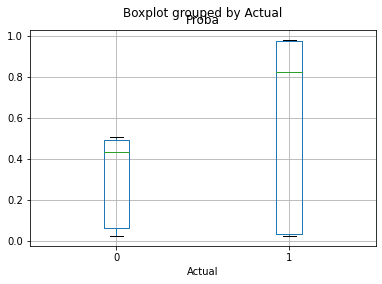

In [90]:
output2.boxplot('Proba', 'Actual')